# Import dependencies

In [1]:
import pandas as pd
import numpy as np
import csv
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from Bio import SeqIO
from sklearn.metrics import ConfusionMatrixDisplay
import os
from dotenv import load_dotenv

load_dotenv()

True

# Import data & convert it to dataframe

In [10]:
enzyme_df = pd.read_csv(os.getenv('ENZYMES'), header=0, sep=',')
enzyme_df = enzyme_df.drop('EC number', axis=1)
enzyme_df = enzyme_df.drop('Entry', axis=1)
with open(os.getenv('NON-ENZYMES')) as file:
    recs = SeqIO.parse(file, 'fasta')
    data = []
    for rec in recs:
        data.append({'id': rec.id, 'sequence': str(rec.seq)})
    non_enzyme_df = pd.DataFrame(data)
    non_enzyme_df = non_enzyme_df.drop('id', axis=1)

#### Look at dataframes

In [3]:
enzyme_df.head()

,Sequence
0,MPAPTQLFFPLVRNCELSRIYGTACYCHHKHLCCSPPYIPQNRLRY...
1,MRLGNAYAYCKPSQNVGLKLDLLRGLPGYVGHATSRINRLENQDNY...
2,MAKLARVVGLVQEEQPSDMTNHPRYSPPPQQPGTPGYAQGQQQTYS...
3,MNKLAVLYAEHIATLQKRTREIIERENLDGVVFHSGQAKRQFLDDM...
4,MEDGPSNNASCFRRLTECFLSPSLTDEKVKAYLSLHPQVLDEFVSE...


In [4]:
non_enzyme_df.head()

,sequence
0,MRKVLKKAALCTFGFSMLFGCASEEDTIVMAPVPVVQNQFEPTTEW...
1,MRYFVIGTMIALAGLLVGGGVGSYFTSSKLLKQFQNIPGSPIVLSA...
2,MICASKITMLGLLVMCTLGGVLGKVDIRQTTANKAFMETMRADGYE...
3,MIICNFMNICMIDPNDVYKWFMEFSLDSYDWVMINNVYSMGLFADG...
4,DCEQHTDCSAASGPVYCCQDSDCCGGVDYICTNYGQCVRHF


 #### Verify data errors

In [5]:
(len(enzyme_df['Sequence']) != 0 ) & (len(non_enzyme_df['sequence']) != 0)

True

In [6]:
len(enzyme_df)

9204

In [7]:
len(non_enzyme_df)

39502

In [8]:
enzyme_df_downsampled = resample(enzyme_df,replace=False,n_samples=5,random_state=42)
print(len(enzyme_df_downsampled))

5


In [9]:
non_enzyme_df_downsampled = resample(non_enzyme_df,replace=False,n_samples=5,random_state=42)
print(len(non_enzyme_df_downsampled))

5


# Format data

In [10]:
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'X']
encoder = OneHotEncoder(categories=[amino_acids])
def one_hot_encode_sequence(sequence):
    res = []
    bin = pd.get_dummies(list(sequence))
    for index, row in bin.iterrows():
        bin_res = []
        for acid in amino_acids:
            if acid not in list(sequence):
               entry = False
            else:
                entry = row[acid]
                #print(str(entry) + " for " + acid)
            bin_res.append(entry)
        res.append(bin_res)

    #test
    sum = 0
    for r in res:
        sum = sum + len(r)
    if len(res) != len(sequence):
        raise Exception("res != seq")
    if len(sequence) * len(amino_acids) != sum:
        raise Exception("aa*seq != sum")

    #print(str(len(sequence)) + " * " + str(len(amino_acids)) + " = " + str(len(sequence) * len(amino_acids)) + " >>> " + str(len(res)) + " -- " + str(sum))
    #print("___")

    return [[int(value) for value in sublist] for sublist in res]

all_data = []

In [11]:
for seq in enzyme_df_downsampled.Sequence:
    bin = one_hot_encode_sequence(seq)
    all_data.append({'label':1, 'sequence':bin})

In [12]:
for seq in non_enzyme_df_downsampled.sequence:
    bin = one_hot_encode_sequence(seq)
    all_data.append({'label':0, 'sequence':bin})

#### Make test and train set

In [13]:
df = pd.DataFrame(all_data)
df = df.sample(frac=1)

In [ ]:
X = df.drop('label', axis=1).copy()
X.head()

In [ ]:
y = df['label'].copy()
y.head()

#### Center and scaling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train = np.array(X_train)

X_train_flatten = []
for seq in X_train:
    #print(seq[0])
    x = np.concatenate(seq[0])
    X_train_flatten.append(x)
print(X_train_flatten)
y_train = np.array(y_train)


X_test = np.array(X_test)
y_test = np.array(y_test)





# SVM

In [24]:
clf_svm = SVC(kernel='linear', random_state=42)
clf_svm.fit(np.array(X_train_flatten), y_train)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7,) + inhomogeneous part.

In [216]:
ConfusionMatrixDisplay.from_estimator(clf_svm, np.array(X_test).reshape(-1,1), np.array(y_test))

NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [288]:
X = np.array([[0, 0, 1, 0, 1, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0]])
y = np.array([1, 0, 0])
clf = SVC(kernel='linear', random_state=42)
clf.fit(X, y)


SVC(kernel='linear', random_state=42)

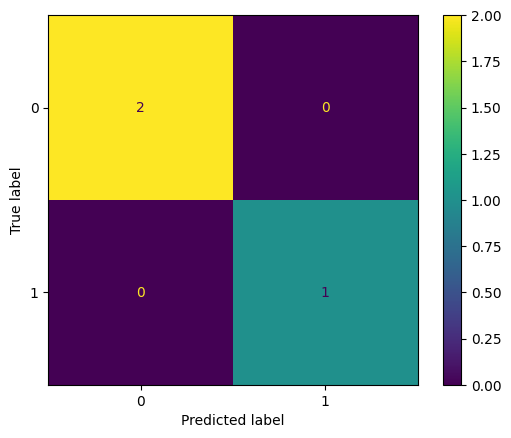

In [289]:
ConfusionMatrixDisplay.from_estimator(clf, np.array([[0, 0, 1, 0, 1, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0]]), np.array([1, 0, 0]))

In [26]:
X = []
y = []
with open(os.getenv('TSV-NON-ENZYMES'), mode='r', newline='') as file:
    tsv_reader = csv.reader(file, delimiter='\t')
    i = 0
    for row in tsv_reader:
        X.append(eval(row[1]))
        y.append(0)
        i += 1
        if i == 10:
            break



with open(os.getenv('TSV-ENZYMES'), mode='r', newline='') as file:
    tsv_reader = csv.reader(file, delimiter='\t')
    i = 0
    for row in tsv_reader:
        X.append(eval(row[1]))
        y.append(1)
        i += 1
        if i == 1000:
            break



In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

clf_svm = SVC(kernel='linear', random_state=42)
clf_svm.fit(np.array(X_train), y_train)

SVC(kernel='linear', random_state=42)

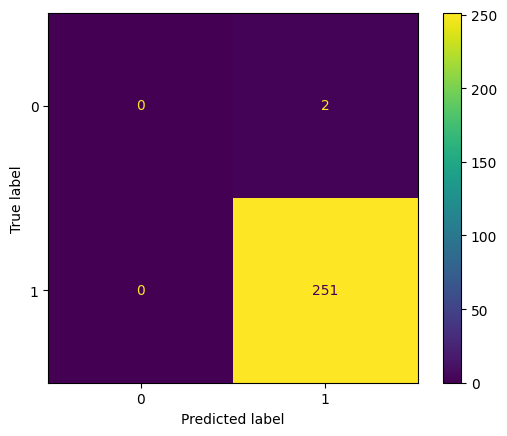

In [28]:
ConfusionMatrixDisplay.from_estimator(clf_svm, X_test, y_test)